# NeRF Tutorial

If you never heard of the technology start with this <a href="https://www.youtube.com/watch?v=JuH79E8rdKc&ab_channel=MatthewTancik">video</a>

<div style="text-align: justify"> This notebook is based in the <a href="https://arxiv.org/abs/2003.08934">NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis</a> paper. I suggest first taking a brief look at the paper, then watching the <a href="https://sites.google.com/berkeley.edu/nerf-tutorial/home">tutorial</a> by the paper authors, and finally reading it carefully.</div>

<div style="text-align: justify">  I've been trying to find an easy way to try out the technology explained in the paper, but I couldn't find anything that worked. So, I decided to give it a shot myself and now I want to share what I learned. Just to be clear, the notebook I made isn't meant to generate new views or anything like that, so it's not specially designed for that. It's just supposed to be a helpful way for people to learn about the technology and it's implementation. The code was not designed for optimal performance, but rather for ease of understanding.</div>

<i>The only thing not implemented is the hierarchical volume sampling. However you can obtain great results without it!</i>

<i>Contact: xxnazarxx@hotmail.es</i>

<i><b>IMPORTANT: GPU (with CUDA) is needed to run the code (otherwise it will be very slow). If you don't have it try to run the code at Google Colab

# Content
* ## 0. Imports 
* ## 1. Data structure
* ## 2. Positional encoding
* ## 3. Model architecture
* ## 4. Rendering
* ## 5. Training

# 0. Imports

Imports used in the notebook. Code device agnostic. Directory creation.

In [1]:
import torch  # For tensor manipulation and general operations
import torchinfo # To show information about the model
import os # Directory manipulation
from pathlib import Path # To save the model
import time # To calculate the time used during the training
import numpy as np # To obtain images that are printable
from tqdm import tqdm # Progress bar
import random # To initialize different values
import torch.nn as nn # Neural network part of the library
import matplotlib.pyplot as plt # To plot the images
from torch.utils.data import DataLoader # To load the data while training

device = 'cuda' if torch.cuda.is_available() else 'cpu' # Let's make the code device agnostic
name = 'novel_views_training' # Path were novel generated views will be stored during the training
os.mkdir(name) if not os.path.isdir(name) else None # Create the directory

# 1. Data 
Let's load the data and analyse its structure.


In [2]:
training_dataset = torch.from_numpy(np.load('training_data.pkl', allow_pickle=True))
testing_dataset = torch.from_numpy(np.load('testing_data.pkl', allow_pickle=True))
# The testing data will be used to generate samples and compare them with the original view.
# There is also the possibility to use it directly to calculate the loss.

In [3]:
training_dataset.shape

torch.Size([16000000, 9])

<div style="text-align: justify"> The shape seems very strange at the beggining. But let's suppose that we have 100 RGB images with shape 400x400 and add to them the origin coordinates and view direction. So we would have a batch of 100 images of shape 400x400 with 9 features corresponding to RGB and the origin coordinates and view direction. So the shape would be (batch, row, col, features) = <b>(100, 400, 400, 9)</b> and features containing (color, origin, view) = (3, 3, 3). If we flatten the first 3 dimmensions we obtain a shape of (batch*row*col, features) = <b>(16000000, 9)</b> , that is exactly what we have. Let's do the inverse process to visualize the data.
</div>

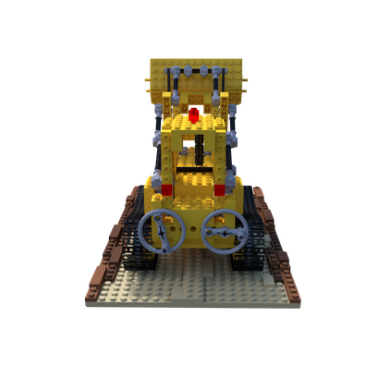

In [4]:
original_shape = training_dataset.reshape((100,400,400,9)) # Inverse reshape
image_data = original_shape[0] # Let's take the first instance
image = image_data[:,:,6:] # Let's take the rgb features ignoring origin and direction
plt.imshow(image)
plt.axis(False)
plt.show()

Let's analyse the other components.

In [5]:
print(image_data[:,:,0].unique(),image_data[:,:,2].unique(),image_data[:,:,2].unique())

tensor([-0.0538]) tensor([1.2081]) tensor([1.2081])


As each image has a unique value for every feature, it can be inferred that these three values represent the camera origin.

In [6]:
print(f"Number of different values for column 3: {len(image_data[:,:,3].unique())} | 4: {len(image_data[:,:,4].unique())} | 5: {len(image_data[:,:,5].unique())}")
print(f"\nFirst five for column 3: {image_data[:,:,3].reshape((400*400))[:5]}")

Number of different values for column 3: 159699 | 4: 155873 | 5: 97991

First five for column 3: tensor([0.3340, 0.3326, 0.3312, 0.3297, 0.3283])


<div style="text-align:justify">In this case, the values exhibit slight variations that are likely attributable to changes in view direction. The accompanying image demonstrates that the camera remains fixed in position across all images, and that each pixel (represented by a blue dot) possesses a distinct directional vector (indicated by a blue line).</div>
<img src="./img/camera.jpg">

<div style="text-align:justify">In NeRF, the loss is computed for each pixel prediction. As a result, it is not necessary to maintain the pixel values in image format, and instead, we can flatten them while preserving the final column. The resulting dimensions of the data would be (pixel_batch, features) = (16000000, 9), where the last dimension preserves the origin, direction, and color for every pixel.</div>

To illustrate, let's print out some values of the origins and directions.

In [7]:
number_examples = 5 # How many sample would you like to print

origins = []
directions = []

for j in range(number_examples):
    pos = random.choice([i for i in range(16000000)])
    origins.append(training_dataset[pos,:3])
    directions.append(training_dataset[pos,3:6])
    
print(f"{number_examples} random origins: {origins}")
print(f"\n{number_examples} random directions: {directions}")

5 random origins: [tensor([-1.3987,  3.5542,  1.2888]), tensor([-0.4875,  1.9912,  3.4710]), tensor([0.8770, 3.8691, 0.7148]), tensor([ 1.9496, -1.4704,  3.2073]), tensor([3.1680, 0.9300, 2.3127])]

5 random directions: [tensor([ 0.4432, -0.7657, -0.4661]), tensor([ 0.1256, -0.3927, -0.9110]), tensor([ 0.0928, -0.9338, -0.3455]), tensor([-0.7209,  0.3527, -0.5965]), tensor([-0.4735, -0.4580, -0.7523])]


# 2. Position encoding
<div style="text-align:justify">To improve the ability of neural networks to represent high-frequency variation in color and geometry, a mapping function is applied to input coordinates to convert them into a higher dimensional space. The mapping function is a positional encoding. The article proposes reformulating the network as a composition of two functions, one learned and one not, which significantly improves performance. A mapping function is used to convert continuous input coordinates into a higher dimensional space to enable the MLP to more easily approximate a higher frequency function.</div>

<img src="./img/encoding.png">

In [8]:
# Expands the feature of the vector
def positional_encoding(x,L=4):
    out = []
    for j in range(L):
        out.append(torch.sin(2**j*x*torch.pi))
        out.append(torch.cos(2**j*x*torch.pi))
    return torch.cat(out, dim=1) # Dimension 1  because we are adding new features(columns) to every vector.

vector = torch.tensor([0.4,0.2,0.9]).unsqueeze(0) # We are supposing that the method recieves a batch of vectors. Here batch is 1.
vector_encoded = positional_encoding(vector)
print(f"The original vector is: {vector} with shape {vector.shape}")
print(f"\nThe encoded vector is: {vector_encoded} with shape {vector_encoded.shape}")

The original vector is: tensor([[0.4000, 0.2000, 0.9000]]) with shape torch.Size([1, 3])

The encoded vector is: tensor([[ 0.9511,  0.5878,  0.3090,  0.3090,  0.8090, -0.9511,  0.5878,  0.9511,
         -0.5878, -0.8090,  0.3090,  0.8090, -0.9511,  0.5878, -0.9511,  0.3090,
         -0.8090,  0.3090, -0.5878, -0.9511, -0.5878, -0.8090,  0.3090, -0.8090]]) with shape torch.Size([1, 24])


As we can observe, our embedding increases the size of the feature columns by a factor of 2*L. With this in mind, we can proceed to construct our model.

# 3. Model
 The model architecture follows the one given at the paper. Details are in the paper at page 18.
 <img src="./img/model_architecture.png">
 
<div style="text-align:justify">The gamma function above is used to encode vectors (function above), transforming their shape from 3 to 2xLx3. In our case, we will calculate two encodings - one for position and one for direction - using different L sizes as parameters for the model. After the code block there is the relation between the code and the diagram above</div>

In [9]:
# Standard neural network used to predict colour and density given the position and view direction.
class NeRFModel(nn.Module):
    
    def __init__(self, embedding_dim_pos=10, embedding_dim_direction=4, hidden_dim=256):
        
        """
        embedding_dim_pos: indicates the augmentation of the position feature. Positional encoding.
        embedding_dim_direction: indicates the augmentation of the direction feature. Positional encoding.
        hidden_dim: indicates the number of hidden layers
        """
        
        super().__init__()
        
        #First store the encoding dimension values (previous L's).
        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        
        # First 5 layers
        self.block1 = nn.Sequential(
            nn.Linear(embedding_dim_pos * 2 * 3, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), # Let's delete some layers to check if all is working properly with smaller model.
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU()   
        )
        
        # Next 4 layers. There is skip connection. The extra dimension at the end is for the sigma above.
        self.block2 = nn.Sequential(
            nn.Linear(embedding_dim_pos * 2 * 3 + hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim + 1)   
        )
        
        # Last block. Outputs the color.
        self.block3 = nn.Sequential(
            nn.Linear(embedding_dim_direction * 2 * 3 + hidden_dim , hidden_dim // 2), nn.ReLU(),
            nn.Linear(hidden_dim // 2, 3), nn.Sigmoid())
        
        self.relu = nn.ReLU()

        
    @staticmethod
    def positional_encoding(x,L):
        out = []
        for j in range(L):
            out.append(torch.sin(2**j*x)*torch.pi)
            out.append(torch.cos(2**j*x)*torch.pi)
        return torch.cat(out, dim=1) 
    
    def forward(self, position, direction):
        emb_position = self.positional_encoding(position, self.embedding_dim_pos)
        emb_direction = self.positional_encoding(direction, self.embedding_dim_direction)
        
        temp = self.block1(emb_position)
        
        #Let's concatenate the position embedding and pass it to the next block.
        temp = self.block2(torch.cat((temp,emb_position), dim=1))
        
        #Let's extract the sigma or density. We have to apply a sigmoid to the sigma to obtain values between 0 and 1.
        temp, sigma = temp[:,:-1], self.relu(temp[:,-1])
        #Let's concatenate the direction embedding and pass it to the next block.
        rgb = self.block3(torch.cat((temp, emb_direction), dim=1))
        return rgb, sigma

<img src="./img/model_torch.png">
<img src="./img/model_forward.png">


In [11]:
nerf = NeRFModel().to(device)
torchinfo.summary(nerf, input_size=[(1,3),(1,3)])

Layer (type:depth-idx)                   Output Shape              Param #
NeRFModel                                [1, 3]                    --
├─Sequential: 1-1                        [1, 256]                  --
│    └─Linear: 2-1                       [1, 256]                  15,616
│    └─ReLU: 2-2                         [1, 256]                  --
│    └─Linear: 2-3                       [1, 256]                  65,792
│    └─ReLU: 2-4                         [1, 256]                  --
│    └─Linear: 2-5                       [1, 256]                  65,792
│    └─ReLU: 2-6                         [1, 256]                  --
│    └─Linear: 2-7                       [1, 256]                  65,792
│    └─ReLU: 2-8                         [1, 256]                  --
│    └─Linear: 2-9                       [1, 256]                  65,792
│    └─ReLU: 2-10                        [1, 256]                  --
├─Sequential: 1-2                        [1, 257]                

Quite big model. Let's create two tensors and pass them through to observe the results."

In [44]:
#Unsqueeze is used because the network expects a batch of positions and directions.
position = torch.rand((1,3)).to(device)
direction = torch.rand((1,3)).to(device)
colour, density = nerf(position, direction)
print(f"Looking at the voxel at {position.to('cpu').numpy()} with {direction.to('cpu').numpy()} direction and the network predicts \
            RGB: {colour.detach().to('cpu').numpy()} and σ: {density.item()}")


Looking at the voxel at [[0.8818467 0.3555056 0.6138016]] with [[0.41927314 0.97337997 0.8024621 ]] direction and the network predicts             RGB: [[0.49664617 0.508261   0.4328715 ]] and σ: 0.0


Let's train our model to predict single voxel values.

In [45]:
colour = torch.tensor([[0.2,0.3,0.5]]).to(device)
sigma = torch.tensor([0.5]).to(device)
nerf.train()
loss_fn1 = torch.nn.MSELoss()
loss_fn2 = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nerf.parameters(), lr=5e-4)
epochs = 10

for i in range(epochs):
    colour_p, sigma_p = nerf(position, direction)
    loss1 = loss_fn1(colour_p,colour)
    loss2 = loss_fn2(sigma_p, sigma)
    loss = loss1 + loss2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

colour, density = nerf(position, direction)
print(f"Looking at the voxel at {position.to('cpu').numpy()} with {direction.to('cpu').numpy()} direction and the network predicts \
            RGB: {colour.detach().to('cpu').numpy()} and σ: {density.item()}")
 

Looking at the voxel at [[0.8818467 0.3555056 0.6138016]] with [[0.41927314 0.97337997 0.8024621 ]] direction and the network predicts             RGB: [[0.13202608 0.22603501 0.52392036]] and σ: 0.0


<div style="text-align:justify"> <i>If the output above has a sigma value of 0.0, I recommend relaunching the model. This may be due to the dying ReLU problem of the density.
</i></div>

<div style="text-align:justify"> <i>The problem is not expected with the general model as there will be more inputs. However, if you obtain a white bunch of images during the training remember this and relaunch the model.
</i></div>

<div style="text-align:justify">Now that we have confirmed that the model performs properly and can predict voxel values, it is time to use these voxel values to predict actual pixels.</div>

# 4. Rendering 
First, we need to calculate the time moments and delta distances. We'll partition the space where the ray exists into n_bins, and then extract a random value from within each bin.
<img src="./img/stratified.png">
The deltas will be calculated as the distance between this new time points.
<img src="./img/deltas.png">


In [46]:
def make_space_partition(tn, tf, n_bins):
    """
    This method makes a partition of the space. It makes n_bins values between tn and tf
    spreaded uniformly. Each consecutive two values represent a bin. 
    """
    return torch.linspace(tn,tf,n_bins+1)

def get_n_points(uniform_partition, device='cpu'):
    """
    This method takes RANDOM points inside each bin. 
    """
    bin_distance = uniform_partition[:,1:] - uniform_partition[:,:-1]
    random_values = torch.rand(bin_distance.shape).to(device)
    return random_values*bin_distance+uniform_partition[:,:-1]

def get_deltas(points, tn=0.0):
    """
    This function return the distances between the calculated times.
    """
    return torch.cat((points[:,0].unsqueeze(1),points[:,1:] - points[:,:-1]),dim = 1)

#Let's show an example of the code behaviour.
tn, tf, n_bins = 0.0, 0.4, 4
unif_space = make_space_partition(tn,tf,n_bins).expand(1,n_bins+1)
points = get_n_points(unif_space)
print(f"The partition space is: {unif_space} \nThe extracted points are {points}")
print(f"The deltas are {get_deltas(points, tn)}")


The partition space is: tensor([[0.0000, 0.1000, 0.2000, 0.3000, 0.4000]]) 
The extracted points are tensor([[0.0335, 0.1871, 0.2132, 0.3406]])
The deltas are tensor([[0.0335, 0.1536, 0.0260, 0.1274]])


Now let's calculate the cumulative density.
<img src="./img/cumulative_density.png">


In [47]:
def compute_accumulated_transmittance(values):
    """
    This function recieves the product of sigma's and delta's and rerutns the accumulated transmittance.
    """
    return torch.exp(-(values.cumsum(dim=1)-values))

<div style="text-align:justify"> We also will need to calculate the different new positions with the following formula: </div>
<img src="./img/ray.png">
<div style="text-align:justify"> For each origin and direction, we'll calculate a new position using the formula we previously defined. Since we have multiple time values, we'll expand the tensor by unsqueezing it to the desired shape. This will give us n points for each time value, so if the shape of the origin and direction tensors is m, we'll have n*m values. Adding the batch shape will give us a final shape of (b, n, m), where we can access the batch with the first dimension, the time with the second dimension, and the coordinate with the third dimension. The accompanying diagram illustrates this behavior, and running the code blocks below will give a deeper understanding.</div>
<img src="./img/ray_shapes.png">

In [48]:
first = torch.tensor([1.,2.,3.]).unsqueeze(0)
second = torch.tensor([5.,10.]).unsqueeze(1)
result = first+second
print(f"The first tensor shape is {first.shape}, the second shape is {second.shape} and the result shape is {result.shape}")
print(f"The tensors were expanded in the 1 size dimensions and then added")
print(f"\nExpanded first: \n{first.expand(2,3).numpy()}")
print(f"Expanded second: \n{second.expand(2,3).numpy()}")
print("Result \n", result.numpy())

The first tensor shape is torch.Size([1, 3]), the second shape is torch.Size([2, 1]) and the result shape is torch.Size([2, 3])
The tensors were expanded in the 1 size dimensions and then added

Expanded first: 
[[1. 2. 3.]
 [1. 2. 3.]]
Expanded second: 
[[ 5.  5.  5.]
 [10. 10. 10.]]
Result 
 [[ 6.  7.  8.]
 [11. 12. 13.]]


In [49]:
origins = torch.tensor([[0.,0.,0.],[1.,1.,1.]])
directions = torch.tensor([[1.,0.,0.],[0.,1.,0.]])
times = torch.tensor([[0.3,0.2],[0.1,0.4]])
o_s = origins.unsqueeze(1) 
t_s = times.unsqueeze(2)
d_s = directions.unsqueeze(1)
print(f"The new shape are origin: {o_s.shape}  |  directions: {d_s.shape}  |  times: {t_s.shape}")
voxel_pos = o_s + t_s * d_s
print(f"The shape of the new tensor is: {voxel_pos.shape}")
print(f"And the Tensor is: \n{voxel_pos.numpy()}")
print(f"\nAt the end after the reshape we join the batch and time dimensions: {voxel_pos.reshape(-1,3)}")

The new shape are origin: torch.Size([2, 1, 3])  |  directions: torch.Size([2, 1, 3])  |  times: torch.Size([2, 2, 1])
The shape of the new tensor is: torch.Size([2, 2, 3])
And the Tensor is: 
[[[0.3 0.  0. ]
  [0.2 0.  0. ]]

 [[1.  1.1 1. ]
  [1.  1.4 1. ]]]

At the end after the reshape we join the batch and time dimensions: tensor([[0.3000, 0.0000, 0.0000],
        [0.2000, 0.0000, 0.0000],
        [1.0000, 1.1000, 1.0000],
        [1.0000, 1.4000, 1.0000]])


<div style="text-align:justify">We can now put everything together and use the formula below to calculate the colours. Note that we'll perform a sum over the first dimension, which allows us to select time.</div>
<img src="./img/pixel_render.png">

In [50]:
def render_rays(nerf_model, ray_origins, ray_directions, tn=0, tf=0.5, n_bins=192):
    device = ray_origins.device
    batch_size = ray_origins.shape[0]
    
    # Sample some times.
    uniform_partition = make_space_partition(tn,tf,n_bins).expand(batch_size,n_bins+1).to(device)
    time_points = get_n_points(uniform_partition,device).to(device)
    deltas = get_deltas(time_points,tn)

    #We expand in order no make the additions. Example above. We obtain shape = [batch, time, direction]
    voxel_pos = ray_origins.unsqueeze(1) + time_points.unsqueeze(2)* ray_directions.unsqueeze(1) 
  
    #The directions will be the same over the time, we have to expand its tensor.
    ray_directions = ray_directions.expand(n_bins, ray_directions.shape[0],3).transpose(0,1)
    
    #Let's obtain the color and density at this voxel_positions with the model. We reshape it.
    colors, sigmas = nerf_model(voxel_pos.reshape(-1,3), ray_directions.reshape(-1,3))
    colors = colors.reshape(voxel_pos.shape)
    sigmas = sigmas.reshape(voxel_pos.shape[:-1]) # The density don't have 3 columns at the end (x,y,z) of the direction.

    #Let's calculate the product of the sigmas and deltas (densities and lengths).
    values = deltas*sigmas
    opacity = compute_accumulated_transmittance(values)

    weights = ((1 - torch.exp(-values))*opacity).unsqueeze(2)
    pixel_colours = (weights * colors).sum(dim=1) # As we have [batch, time, color] we sum over times (voxels that ray goes through).
    
    #Now suppose that we sample a ray that has nothing, we want the background white.
    weight_sum = weights.sum(-1).sum(-1)  # We can know how much opacity we had.
    background_color = torch.tensor([1.,1.,1.]).unsqueeze(0).to(device)*(1-weight_sum.unsqueeze(1)) # First tensor specifies the color.

    return background_color + pixel_colours # Finally return the pixel colours that our networks predicts for every camara origin + view direction    

In [51]:
 render_rays(nerf,origins.to(device),directions.to(device),n_bins=5) # The result will be very close or almost 1.

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0', grad_fn=<AddBackward0>)

You can analyse the output above in different ways. You can print sigma values and realize that they are very low.
This makes the color dependd mainly on the background. You can print background to see it's high values.
You can imagine this scene like a empty space with white background and with little fog.

Let's create a method to show our generated images.

100%|███████████████████████████████████████████| 40/40 [00:08<00:00,  4.99it/s]


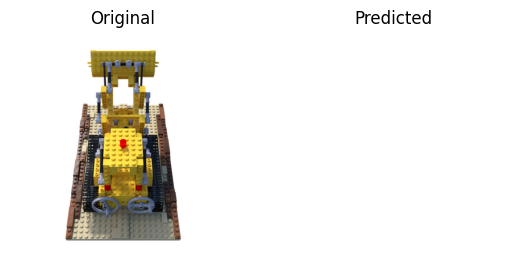

In [52]:
@torch.no_grad()
def show_generated(model, dataset, img_index=0, tn = 2.0, tf = 6.0,  chunk_size=10,  n_bins=192, H=400, W=400):
    """
    This method allows to print an image created by the network.
    """
    colors = dataset[img_index * H * W: (img_index + 1) * H * W, 6:]
    ray_origins = dataset[img_index * H * W: (img_index + 1) * H * W, :3]
    ray_directions = dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]

    data = []
    total = int(np.ceil(H / chunk_size))

    for i in tqdm(range(total)):
        ray_origins_ = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        ray_directions_ = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)

        regenerated_px_values = render_rays(model, ray_origins_, ray_directions_, tn=tn, tf=tf, n_bins=n_bins)
        data.append(regenerated_px_values)

    predicted_image = torch.cat(data).data.cpu().numpy().reshape(H, W, 3)
    original_image = colors.squeeze().reshape(H, W, 3)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(original_image)
    plt.title("Original")
    plt.axis(False)    
    plt.subplot(1,2,2)   
    plt.imshow(predicted_image)
    plt.title("Predicted") 
    plt.axis(False)
    plt.show()
    return predicted_image
    
predicted_image = show_generated(nerf,testing_dataset,0)

<i>With a RTX3060 the generation time takes about 8 seconds.</i>

<div style="text-align: justify"> The resulting image may appear mostly white due to the high concentration of density values close to zero. 
    
With our method for generating images from a neural network in place, we can now move forward with training it to produce the desired images. Additionally, we'll include a test function that can generate samples with different views based on the test dataset</div>

In [53]:
def train(model, optimizer, scheduler, loss_fn, data_loader, testing_dataset, device='cpu', tn=2., tf=6., n_epochs=12, n_bins=192, H=400, W=400):
    
    training_loss = []
    total_time = 0
    
    for _ in tqdm(range(n_epochs)):
        
        start = time.time()
        total_time = 0
        epoch_time = 0
        i = 0
        
        for batch in data_loader:
            
            # Just to print the times. Can delete the following lines
            i+=1
            if i%3125 == 0:  
                elapsed = time.time()-start
                start = time.time()
                total_time += elapsed
                epoch_time += elapsed
                print(f"Currently at {i} / {15625}   ||  Batch time: {elapsed}  ||  Epoch time: {epoch_time}") 
    
            ray_origins = batch[:,:3].to(device) # Input data (x): ray origin
            ray_directions = batch[:,3:6].to(device) # Input data (x): ray direction
            ground_truth_px_values = batch[:, 6:].to(device) # Expected output value (y_true)
            
            # The following generate the Predicted output value (y_pred)
            regenerated_px_values = render_rays(model, ray_origins, ray_directions, tn=tn, tf=tf, n_bins=n_bins)
            loss = loss_fn(ground_truth_px_values, regenerated_px_values)
            
            # Let's update the model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Append to the loss list.
            training_loss.append(loss.item())
        
        
        print(f"Total epoch time {epoch_time}  |  Loss: {loss}")
        epoch_time = 0
        scheduler.step() 
        
        # Let's save some generated images.
        for img_index in range(200):
            test(_, tn, tf, testing_dataset, img_index=img_index, n_bins=n_bins, H=H, W=W)
            
    return training_loss

In [54]:
@torch.no_grad()
def test(epoch, tn, tf, dataset, chunk_size=10, img_index=0, n_bins=192, H=400, W=400):
    
    # Let's take the origin and direction of the ssample.
    ray_origins = dataset[img_index * H * W: (img_index + 1) * H * W, :3]
    ray_directions = dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]
    
    # We will render the image in chunks pf pixels
    data = []
    for i in range(int(np.ceil(H / chunk_size))):
        ray_origins_ = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        ray_directions_ = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)

        regenerated_px_values = render_rays(nerf, ray_origins_, ray_directions_, tn=tn, tf=tf, n_bins=n_bins)
        data.append(regenerated_px_values)
        
    # Let's join this chunks
    img = torch.cat(data).data.cpu().numpy().reshape(H, W, 3)

    plt.figure()
    plt.imshow(img)
    plt.savefig(f'novel_views_training/epoch_{epoch}_img_{img_index}.png', bbox_inches='tight')
    plt.close()

In [57]:
#Let's prepare training parameters.
optimizer = torch.optim.Adam(nerf.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4,8], gamma=0.5)
loss_fn = torch.nn.MSELoss()
data_loader= DataLoader(training_dataset, batch_size=1024, shuffle=True)
nerf = NeRFModel().to(device)

Since we have confirmed that everything is working, let's train our model and see how it performs. We expect the model to generate good-looking results even from the first epoch.

In [ ]:
train(nerf, optimizer, scheduler, loss_fn, data_loader, testing_dataset, device, tn=2, tf=6, n_bins=192, H=400, W=400)

<i>With a RTX3060 the time to run an epoch is about 40 minutes.</i>

Now that our model is trained let's save it!

In [49]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "NeRF_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=nerf.state_dict(), f=MODEL_SAVE_PATH)

<div style="text-align:justify">I hope this tutorial has been helpful in understanding the implementation of NeRF. Please don't hesitate to reach out if you have any questions or suggestions. I'm always happy to assist in any way I can.
My email is: xxnazarxx@hotmail.es</div>